In [50]:
import torch
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random
torch.manual_seed(0)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from Data_Loader import *
from Generator import *

In [4]:
device = 'cuda'
n_channels = 3
image_shape = (640,480)
batch_size = 4

## Loading pre-trained model

In [5]:
classifier = models.resnet50(weights=False)
num_features = classifier.fc.in_features
classifier.fc = nn.Linear(num_features, 6)
classifier = classifier.to(device)
pretrained_weights_path = '/content/drive/MyDrive/SER_Teess_Savee_Ravdess_classifier.pth'
classifier.load_state_dict(torch.load(pretrained_weights_path))
classifier.fc = torch.nn.Identity()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
import scipy
def matrix_sqrt(x):
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    return torch.Tensor(y.real, device=x.device)

In [7]:
def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
    return torch.norm(mu_x-mu_y)*torch.norm(mu_x-mu_y)+ torch.trace(sigma_x + sigma_y - 2 * matrix_sqrt(sigma_x @ sigma_y))

In [8]:
def preprocess(img):
    img = torch.nn.functional.interpolate(img, size=(224, 224), mode='bilinear')
    return img

In [9]:
def get_covariance(features):
    return torch.Tensor(np.cov(features.detach().cpu().numpy(), rowvar=False))

In [10]:
def get_noise(n_samples, n_channels,image_shape, device='cuda'):
    return torch.randn(n_samples,n_channels, image_shape[0],image_shape[1], device=device)

In [11]:
import os
import shutil
def remove_all_directories(directory):
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)

        if os.path.isdir(item_path):
            shutil.rmtree(item_path)

In [12]:
def get_stat(fake_features_list,real_features_list):
    fake_features_all = torch.cat(fake_features_list)
    real_features_all = torch.cat(real_features_list)
    mu_fake = torch.mean(fake_features_all,0)
    mu_real = torch.mean(real_features_all,0)

    sigma_fake = get_covariance(fake_features_all)
    sigma_real = get_covariance(real_features_all)
    return mu_fake, mu_real, sigma_fake, sigma_real

In [17]:
def load_model(emotion,path='Gan_Results/Models'):
    path_tmp = f'{path}/{emotion}'
    remove_all_directories(path_tmp)

    model_path = os.listdir(path_tmp)[0]
    model_path = f'{path_tmp}/{model_path}'

    gen = Generator(n_channels, n_channels).to(device)
    gen.load_state_dict(torch.load(model_path, map_location=torch.device(device))["gen_AB"])
    return gen


## Calculating the Fid-score on synthetic Spectograms

In [45]:
def find_fid(emotion):
    target_dataset = FilteredDataset(dataset,emotion)
    target_loader = DataLoader(target_dataset, batch_size=batch_size, shuffle=True)
    fake_features_list = []
    real_features_list = []
    gen = load_model(emotion,path='Gan_Results/Models')
    with torch.no_grad():
        for real_image, _ in target_loader:
            real_image = real_image.to(device)
            Resnet_real = preprocess(real_image)
            real_features = classifier(Resnet_real)
            real_features_list.append(real_features)

            #fake_image = gen(get_noise(len(real_image), n_channels,image_shape, device='cuda'))
            fake_image = gen(real_image)
            fake_image = preprocess(fake_image)
            fake_features = classifier(fake_image)
            fake_features_list.append(fake_features)
    mu_fake, mu_real, sigma_fake, sigma_real = get_stat(fake_features_list,real_features_list)
    cur_fid = frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item()
    print(f'FID Score for {emotion} is: {cur_fid}')
    return cur_fid

In [46]:
Emotions = dataset.classes

In [47]:
fid_scores = {}
for emotion in Emotions:
    fid_scores[emotion] = find_fid(emotion)

FID Score for Angry is: 13.312173843383789
FID Score for Happy is: 11.668828010559082
FID Score for Neutral is: 44.127960205078125
FID Score for Sad is: 11.823298454284668
FID Score for Surprise is: 12.969532012939453


## Comparing the Fid-score over all emotions

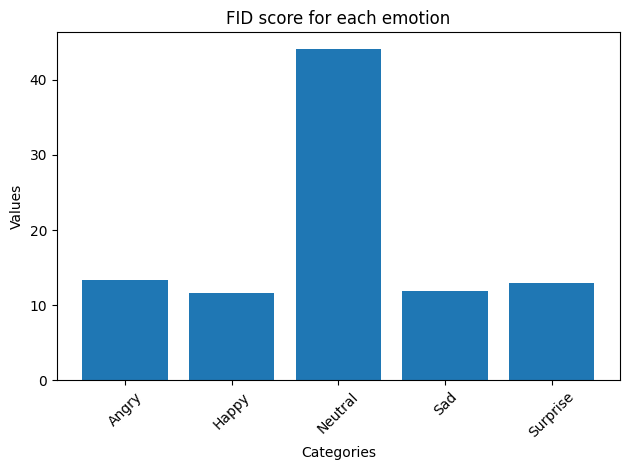

In [48]:
import matplotlib.pyplot as plt

categories = list(fid_scores.keys())
values = list(fid_scores.values())

plt.bar(categories, values)

plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('FID score for each emotion')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Calculating the Fid-score on real Spectograms

In [61]:
def find_local_fid(emotion):
    target_dataset = FilteredDataset(dataset,emotion)
    target_loader = DataLoader(target_dataset, batch_size=1, shuffle=True)
    fake_features_list = []
    real_features_list = []
    with torch.no_grad():
        for real_image, _ in target_loader:
            real_image = real_image.to(device)
            Resnet_real = preprocess(real_image)
            real_features = classifier(Resnet_real)
            real_features_list.append(real_features)

            fake_image = target_dataset[5][0]
            fake_image = fake_image.to(device)
            fake_image = preprocess(fake_image.unsqueeze(0))
            fake_features = classifier(fake_image)
            fake_features_list.append(fake_features)
    mu_fake, mu_real, sigma_fake, sigma_real = get_stat(fake_features_list,real_features_list)
    cur_fid = frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item()
    print(f'FID Score for {emotion} is: {cur_fid}')
    return cur_fid

## Comparing the Fid-score over all emotions

In [62]:
fid_scores = {}
for emotion in Emotions:
    fid_scores[emotion] = find_local_fid(emotion)

FID Score for Angry is: 2.9550743103027344
FID Score for Happy is: 2.8438141345977783
FID Score for Neutral is: 2.9603734016418457
FID Score for Sad is: 2.916569471359253
FID Score for Surprise is: 2.709850788116455


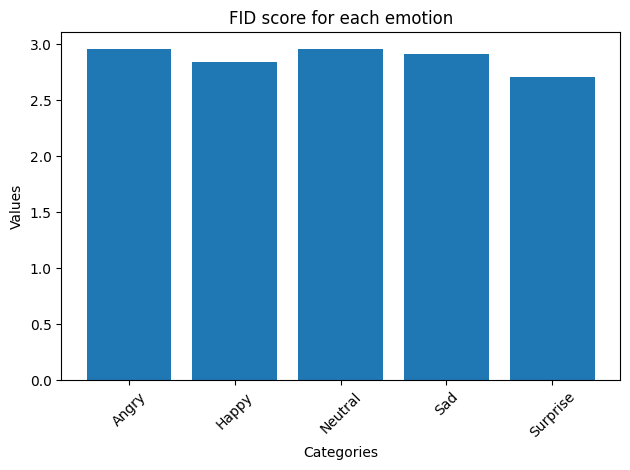

In [63]:
import matplotlib.pyplot as plt

categories = list(fid_scores.keys())
values = list(fid_scores.values())

plt.bar(categories, values)

plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('FID score for each emotion')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()